# Simple Linear Regression

In [412]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from ExtraFunctions import DataFrameSelector, CategoricalEncoder
data = pd.read_csv("data/airbnb/listings-2017.csv")
num_features = ['amenities', 'bedrooms', 'number_of_reviews', 'review_scores_rating', 'accommodates', 'cleaning_fee', 'guests_included', 'beds', 'bathrooms', 'price']
cat_features = [ 'neighbourhood_cleansed', 'room_type', 'bed_type', 'property_type']

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### We clean the data and remove any obvious outliers

In [413]:
df = data[num_features].copy()

df = df[data.price != 0]
df.fillna('0', inplace=True)

# We delete any listing that doesn't have at least one bed
df = df[df.beds != 0]
df['cleaning_fee']  = df['cleaning_fee'].str.replace('$', '').astype(float)
df = pd.concat([df, data[cat_features]], axis=1)

labels = np.asarray([float(p.replace('$', '').replace(',', '')) for p in df.price.values])

df['quality'] = (df.amenities.str.count(',') + 1).astype(float) * ((df['number_of_reviews']).astype(float) + 1) *  ((df['review_scores_rating']).astype(float) + 1)   

# we remove amenities and price which we don't need anymore
num_features.remove('amenities')
num_features.remove('price')

# we add the newly created quality feature
num_features.append('quality')

### We create the d pre-processing pipeline and pass our data through it

In [414]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, PolynomialFeatures


num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_features)),
    ('cat_encoder', CategoricalEncoder())
])

# now we can define the full pipeline

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
data_prepared = full_pipeline.fit_transform(df)

### We split the data to obtain the training & test test whilist keeping count of indices for later use 

In [415]:
from sklearn.model_selection import train_test_split

indices = np.arange(data_prepared.shape[0])

X_train, X_test, y_train, y_test, idx1, idx2 = train_test_split(data_prepared, labels, indices, test_size=0.2, random_state=42)

### We run Linear regression and take some metrics

In [416]:
from sklearn import linear_model
from sklearn import metrics

lin = linear_model.LinearRegression()

train_errors, test_errors = 0, 0

lin.fit(X_train, y_train)
y_train_predict = lin.predict(X_train)
y_test_predict = lin.predict(X_test)
train_error = metrics.median_absolute_error(y_train_predict, y_train)
test_error = metrics.median_absolute_error(y_test_predict, y_test)
score = lin.score(X_test, y_test)

In [417]:
train_error, test_error

(24.34398877086015, 23.611750022904914)

### Plotting Residuals

Saving figure residual_plot


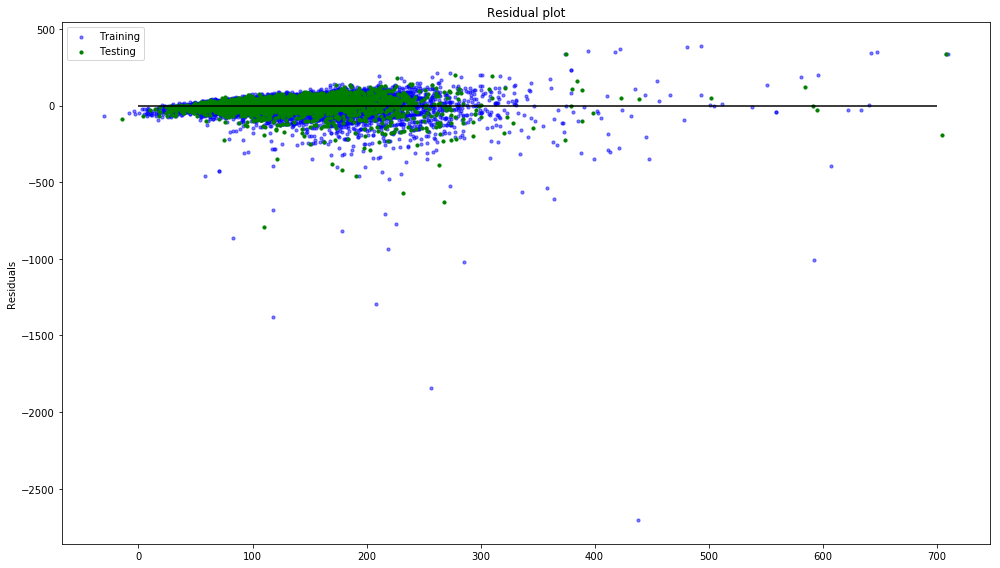

In [418]:
plt.figure(figsize=(14, 8))
plt.scatter(y_train_predict, y_train_predict - y_train, c='b', s=10, alpha=0.5, label='Training')
plt.scatter(y_test_predict, y_test_predict - y_test, c = 'g', s=10, label='Testing')
plt.hlines(y=0, xmin=0, xmax=700)
#plt.ylim([-1000, 500])
plt.ylabel("Residuals")
plt.title('Residual plot')
plt.legend()
#save_fig("residual_plot")

### How well is our data being classified?

In [419]:
bracket = 40
within_30 = (len(y_test[abs(y_test_predict - y_test) < bracket]) / len(y_test)) * 100
print('{:0.2f}% of test are within {}€'.format(within_30, bracket))

70.86% of test are within 40€


### Let's analyse the largest mistakes

In [420]:
min_index = (y_train_predict - y_train) < -1000
min_index = np.where(min_index)[0]
df_index = idx1[min_index]
mistakes_df = df.iloc[df_index].copy()
mistakes_df['mistakes'] = (y_train_predict - y_train)[min_index]
mistakes_df['mistakes'] = mistakes_df['mistakes'].map('${:0,.2f}'.format)
mistakes_df

,amenities,bedrooms,number_of_reviews,review_scores_rating,accommodates,cleaning_fee,guests_included,beds,bathrooms,price,neighbourhood_cleansed,room_type,bed_type,property_type,quality,mistakes
14564,"{""Wireless Internet"",Kitchen,""Smoking allowed""...",2,0,0,2,0.0,1,1,1,"$1,500.00",Geuzenveld - Slotermeer,Entire home/apt,Real Bed,House,12.0,"$-1,381.81"
1537,"{TV,""Wireless Internet"",Kitchen,Heating,""Famil...",7,1,100,16,90.0,1,16,3.5,"$1,600.00",Centrum-West,Entire home/apt,Real Bed,Apartment,3838.0,"$-1,007.44"
4183,"{""Wireless Internet"",""Pets allowed"",Breakfast,...",1,0,0,16,0.0,1,6,1,"$3,142.00",Centrum-Oost,Entire home/apt,Real Bed,Bed & Breakfast,7.0,"$-2,704.36"
10724,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",2,0,0,4,70.0,4,2,1.5,"$1,500.00",Zuid,Entire home/apt,Real Bed,Apartment,16.0,"$-1,291.89"
2632,"{TV,""Wireless Internet"",Kitchen,Heating,Washer...",1,1,100,4,0.0,1,3,1.5,"$2,100.00",Centrum-West,Entire home/apt,Real Bed,Other,2828.0,"$-1,843.41"
770,"{TV,Internet,""Wireless Internet"",""Air conditio...",3,2,100,6,0.0,1,3,3,"$1,305.00",Oud-Noord,Entire home/apt,Real Bed,Other,4545.0,"$-1,019.34"
